In [1]:
# TODO: Fix the validation loss

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torchvision
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from google.colab import drive
from tqdm.auto import tqdm
from timeit import default_timer as timer
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
data_path = '/content/drive/MyDrive/facial-keypoints-detection/training.zip'
test_path = "/content/drive/MyDrive/facial-keypoints-detection/test.zip"

In [57]:
data = pd.read_csv(data_path, compression="zip")
test = pd.read_csv(test_path, compression="zip")["Image"]

In [6]:
test

0       182 183 182 182 180 180 176 169 156 137 124 10...
1       76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2       177 176 174 170 169 169 168 166 166 166 161 14...
3       176 174 174 175 174 174 176 176 175 171 165 15...
4       50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
                              ...                        
1778    101 101 101 100 100 97 97 98 102 149 214 206 1...
1779    201 191 171 158 145 140 136 130 123 115 108 10...
1780    28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...
1781    104 95 71 57 46 52 65 70 70 67 76 72 69 69 72 ...
1782    63 61 64 66 66 64 65 70 69 70 77 83 63 34 22 2...
Name: Image, Length: 1783, dtype: object

## Initial Data Visualization

In [7]:
def create_list_of_tuple_pixel(pixel_list):
  pixel_tuple_list = []
  for i in range(1, len(pixel_list), 2):
    pixel_tuple_list.append((pixel_list[i-1], pixel_list[i]))
  
  return pixel_tuple_list

In [8]:
def list_pixels_to_img(img_list):
  img = list(map(int, img_list.split(" ")))
  img = np.array(img)
  img = np.reshape(img, (96,96))
  return img

In [9]:
def plot_image_with_keypoints(img, pixel_tuple_list):
  
  plt.imshow(img, cmap = "gray")
  for x,y in pixel_tuple_list:
    plt.scatter(x,y, c = "r")
  plt.axis(False);

In [10]:
def plot_image_index(index):
  image = data["Image"].iloc[index]
  data_points = data.iloc[index][:-1].to_list()
  pixel_tuple_list = create_list_of_tuple_pixel(data_points)
  image = list_pixels_to_img(image)
  plot_image_with_keypoints(image, pixel_tuple_list)

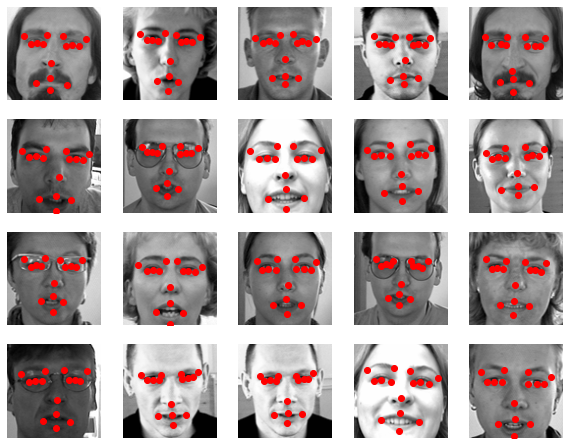

In [11]:
fig = plt.figure(figsize = (10,10))
nrows = 5
ncols = 5
for i in range(20):
  ax = fig.add_subplot(nrows, ncols, i+1)
  plot_image_index(i)

In [58]:
# Checking number of null values
data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

### Plotting different distributions to see initial probability distributions

In [13]:
num_features = len(data.columns[:-1])
num_features

30

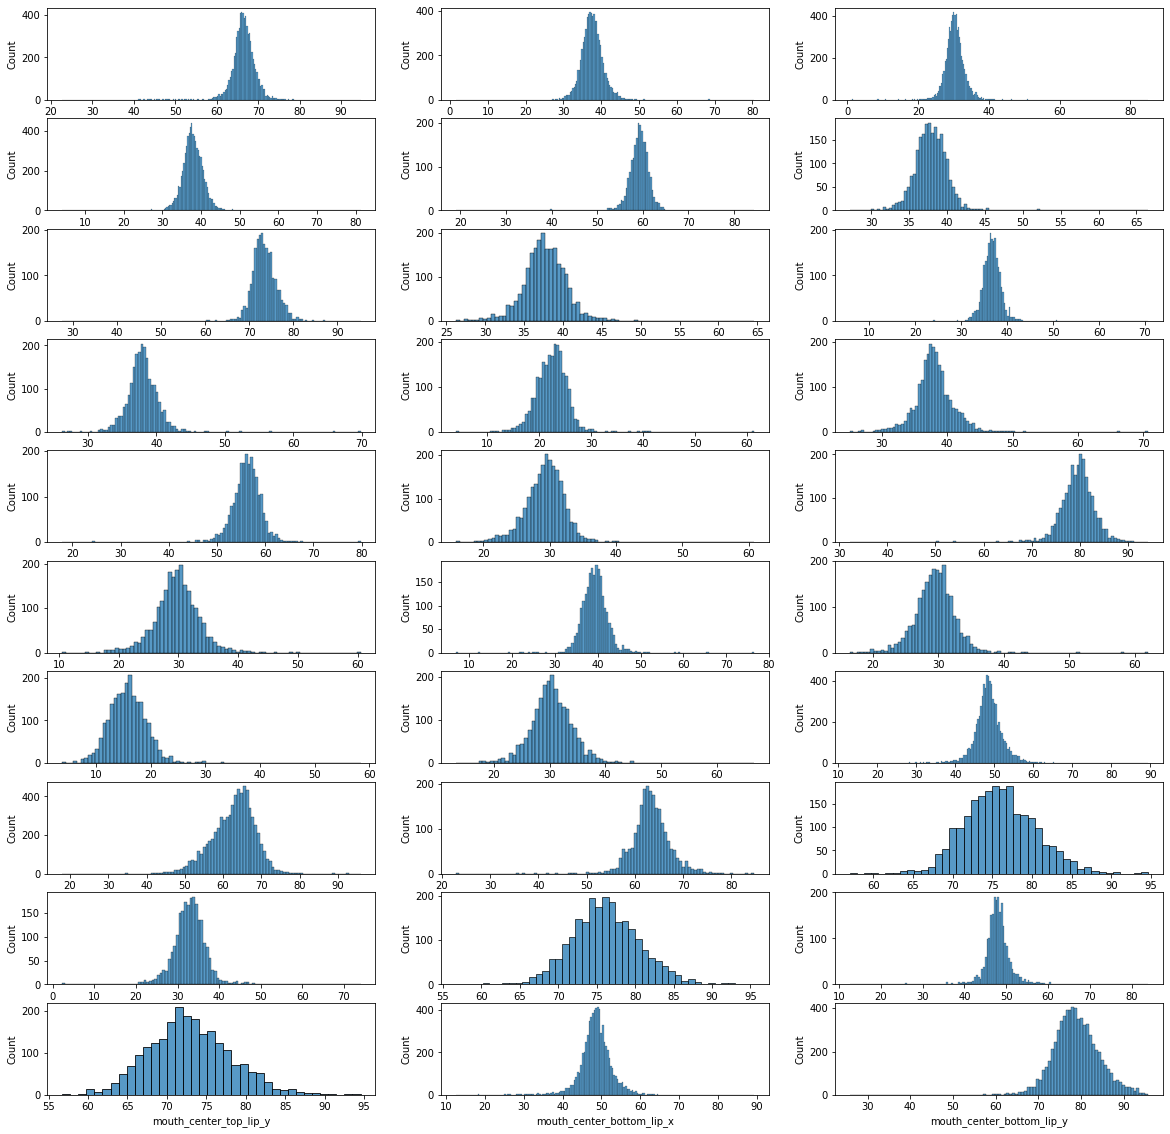

In [14]:
# Plotting the distributions
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 20)) 
for i, column in enumerate(data.columns[:-1]):
    sns.histplot(data=data, x=column, ax=axes[i // 3, i % 3])

#### To deal with the NaN values I will first try removing them

### Imput the NaN values

In [15]:
# Check how many NaN values there are
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [62]:
# Call for the SimpleImputer
# imputer = SimpleImputer(strategy = "mean")

# Find all numerical columns
numerical_columns = data.select_dtypes(include=float).columns.tolist()

# Impute the missing values
# data[numerical_columns] = imputer.fit_transform(data[numerical_columns])

In [59]:
data.fillna(method = "ffill", inplace = True)

In [60]:
# Check to see if the NaN values have been imputed
data.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

## Preparing the Training/Test Data and Model

### Creating train/validation split and batches

In [63]:
# Getting the X, y datasets
X, y = data["Image"], data[numerical_columns]

# Converting the pandas DataFrames to NumPy arrays
X = np.array(list(map(lambda x: list(map(int, x)), X.str.split(" ").tolist())))/255
y = y.to_numpy()

# Creating training and validation data
test_split = 0.65
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_split, random_state = 42) 

In [64]:
# Taking the training and validation data into torch tensors
train_datatensor = torch.utils.data.TensorDataset(torch.from_numpy(X_train).type(torch.float), torch.from_numpy(y_train).type(torch.float))
val_datatensor = torch.utils.data.TensorDataset(torch.from_numpy(X_val).type(torch.float), torch.from_numpy(y_val).type(torch.float))

In [65]:
# Taking the training and validation tensors into batches
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(train_datatensor, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_datatensor, batch_size=BATCH_SIZE, shuffle=False)

In [66]:
# Check out what is inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 9216]), torch.Size([32, 30]))

In [67]:
val_features_batch, val_labels_batch = next(iter(val_dataloader))
val_features_batch.shape, val_labels_batch.shape

(torch.Size([32, 9216]), torch.Size([32, 30]))

### Model, Loss, and Optimizer
- For a baseline, I will use my own model
- Then I will use a Resnet 50 model

In [71]:
# Creating Basic CNN
class FacialKeyPointsModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(1,4, kernel_size=3,padding = 1),
        nn.ReLU(),
        nn.Conv2d(4,16, kernel_size=3,padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size = 3),
        nn.ReLU(),
        nn.Conv2d(32,64, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(64,128, kernel_size=5),
        nn.ReLU(),
        nn.Conv2d(128,256, kernel_size=5),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_layer4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size = 3),
        nn.ReLU(),
        nn.Conv2d(512, 1024, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(1024),
        nn.MaxPool2d(kernel_size=2)
    )
    self.linear_layers = nn.Sequential(
        nn.Linear(1024, 256),
        nn.Linear(256, 30)
    )
  def forward(self, x):
    x = self.conv_layer1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_layer2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.conv_layer3(x)
    # print(f"Output shape of conv_block_3: {x.shape}")
    x = self.conv_layer4(x)
    # print(f"Output shape of conv_block_4: {x.shape}")
    x = x.view(x.shape[0],-1)
    x = self.linear_layers(x)
    # print(f"Output shape of linear_layer: {x.shape}")
    return x

In [72]:
# Creating Toy Data to Make Sure Model is Working
toy_model = FacialKeyPointsModel()
rand_image_tensor = torch.randn(size = (32, 1,96,96))
toy_model(rand_image_tensor)

tensor([[-1.4553e-01, -5.9934e-01, -4.6257e-01,  3.9855e-01, -3.6248e-01,
         -7.7663e-01,  7.6974e-01,  1.4061e+00, -1.4157e-01,  2.8789e-01,
         -5.0447e-02,  1.2730e-01,  2.6385e-01, -1.5566e-01, -3.6714e-01,
          6.0804e-01,  3.4987e-01, -3.7293e-01,  2.3966e-01, -5.0075e-02,
          4.9012e-01, -3.7165e-02, -2.6994e-01, -1.4478e-02,  6.8063e-01,
         -4.9998e-01,  1.3438e-01, -3.3364e-01, -3.0274e-01, -1.8447e-01],
        [ 5.8684e-02, -1.7239e+00, -5.1438e-01, -3.7473e-01, -6.8654e-01,
         -2.0299e-01,  1.4358e+00,  1.3180e-01, -3.8397e-01,  5.7231e-01,
         -4.5092e-01,  1.4846e-01, -5.6880e-01,  6.7361e-01, -5.1396e-02,
         -6.7625e-01,  6.2296e-01, -2.0600e-01, -2.8870e-01,  3.8384e-02,
          3.2317e-01, -5.2139e-02, -6.2584e-01,  5.7238e-01,  9.4335e-01,
         -1.1346e-01,  3.0290e-01, -7.1825e-01, -1.2981e-01, -8.1012e-01],
        [ 9.8050e-01, -1.1637e+00, -2.6944e-01,  9.0527e-01,  2.8326e-01,
         -1.7872e-01,  1.5422e-01,  

In [24]:
# # Calling on Resnet
# model = torchvision.models.resnet18(pretrained=True)

# # Initializing layers
# model.fc = torch.nn.Linear(model.fc.in_features, 30)
# model.conv1 =  nn.Conv2d(1, 64, 7, stride=2, padding=3, bias=False)

# # Changing model type
# model = model.type(torch.FloatTensor).to(device)

In [103]:
# Initialize Model
model = FacialKeyPointsModel()

In [87]:
# resnet50 = torchvision.models.resnet50(num_classes = 30)
# resnet50.inplanes = 96
# resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
#                                bias=False)
# model = resnet50

In [104]:
# Loss Function
loss_fn = nn.MSELoss()

# Optimizer 
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.0001)

### Creating the Training Loop

In [105]:
# Starting time 
start_time = timer()

# Number of Epochs
epochs = 10

# Setting the model to the correct device
model = model.to(device)

# Collect training and validation loss to plot
train_losses = []
val_losses = []
num_epochs = []

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    # Setting data to the device and flatten
    X, y = X.to(device), y.to(device)
    model.train()
    # Forward step 
    X = X.reshape(X.shape[0], 96, 96)
    X = torch.unsqueeze(X, dim = 1)
    # print(f"Shape of X before model is: {X.shape}")
    # print(f"Shape of y is: {y.shape}")
    y_pred = model(X)
    # print(f"Shape of predicted y is: {y_pred.shape}")
    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad

    # Backpropagation
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print out progress
    if batch % 50 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Calculate the train loss average
  train_loss /= len(train_dataloader)
  train_losses.append(train_loss)
  # Validation

  # Calculate the validation loss
  val_loss = 0
  model.eval()
  with torch.inference_mode():
    for X_val, y_val in val_dataloader:
      X_val = X_val.reshape(X_val.shape[0], 96, 96)
      X_val = torch.unsqueeze(X_val, dim = 1)

      # Setting data to the device and flatten
      X_val, y_val = X_val.to(device), y_val.to(device)

      # Forward Pass
      val_pred = model(X_val)

      # Calculate Validation Loss
      val_loss += loss_fn(val_pred, y_val)

    # Calculate the validation loss average
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
  
  num_epochs.append(epoch)
  # Print
  print(f"\nTrain loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# Calculate the training time
end_time = timer()
print(f"Total time taken: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Train loss: 1315.2622 | Val Loss: 877.0383
Epoch: 1
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Train loss: 438.5382 | Val Loss: 4157.8994
Epoch: 2
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Train loss: 730.0006 | Val Loss: 1964.6448
Epoch: 3
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Train loss: 688.2449 | Val Loss: 676.2879
Epoch: 4
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Train loss: 642.7054 | Val Loss: 698.7347
Epoch: 5
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Train loss: 424.5343 | Val Loss: 589.0798
Epoch: 6
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Train loss: 535.6791 | Val Loss: 389.8986
Epoch: 7
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Train loss: 337.7469 | Val Loss: 527.0275
Epoch: 8
---------
Looked at 0/2467 samples
Looked at 1600/2467 samples

Trai

## Evaluate the Model

In [91]:
# Making predictions 
model.eval()
with torch.inference_mode():
  for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)
    X = X.reshape(X.shape[0], 96, 96)
    X = torch.unsqueeze(X, dim = 1)
    test_pred = model(X)

  0%|          | 0/144 [00:00<?, ?it/s]

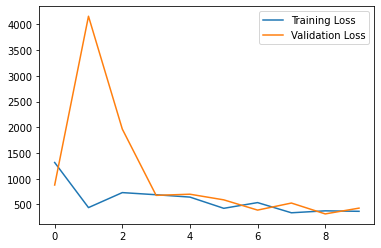

In [111]:
# Plot the test and validation losses
plt.plot(num_epochs, np.array(torch.tensor(train_losses).cpu()), label = "Training Loss")
plt.plot(num_epochs, torch.tensor(val_losses).cpu(), label = "Validation Loss")
plt.legend()

In [ ]:
# test = np.array(list(map(lambda x: list(map(int, x)), test.str.split(" ").tolist())))/255